# Session 3 - AutoML and Closing Thoughts

This is an introductory notebook to familiarize yourself with training and evaluation techniques for Machine Learning (ML) using AutoML. For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument  and the Scikit-learn library to perform water classification. This same workflow can be adapted to other applications and by using other algorithms.

Author: Jordan A. Caraballo-Vega, Caleb S. Spradlin
Release Date: 2023.04.08
Last Modified: 2023.04.26

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.


In [ ]:
!wget https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py

--2023-04-26 11:09:26--  https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6189 (6.0K) [text/plain]
Saving to: ‘folium_helper.py’

folium_helper.py    100%[===================>]   6.04K  --.-KB/s    in 0s      

2023-04-26 11:09:26 (58.4 MB/s) - ‘folium_helper.py’ saved [6189/6189]



In [ ]:
!pip install datasets rasterio pyproj auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
import os
import sys
import csv
import time
import glob
import joblib
import datasets
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

from huggingface_hub import snapshot_download

import autosklearn.classification
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal
import folium
from folium import plugins
import folium_helper

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables
In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [ ]:
# directory where we will output figures
FIGURE_OUTPUT_DIR = 'output'

# directory where we will output raster
RASTER_OUTPUT_DIR = 'output'

# directory where we will output our models
MODEL_OUTPUT_DIR = 'models'

# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

# ratio of the dataset split for testing
TEST_RATIO = 0.2

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

# columns not needed for training
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)

# columns used as features during training
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Here we create an output directory to store any artifacts out of our models and visualizations.

In [ ]:
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

Output any columns we will need to drop for training



In [ ]:
colsToDrop

['x_offset', 'y_offset', 'year', 'julian_day']

In [ ]:
colsToDropTraining

['x_offset',
 'y_offset',
 'year',
 'julian_day',
 'x_offset',
 'y_offset',
 'year',
 'julian_day',
 'tileID']

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:

- Read in data to a Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [ ]:
%%time
train_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='train'))
test_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='test'))

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/nasa-cisto-data-science-group___csv/nasa-cisto-data-science-group--modis-lake-powell-toy-dataset-b44b60340eda6604/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


CPU times: user 660 ms, sys: 42.9 ms, total: 703 ms
Wall time: 3.53 s


After we download our dataset, we proceed to split it into training and test set. Note how the water column is set as the y feature and is dropped from the X features.

In [ ]:
X_train, y_train = train_dataset.drop(['water'], axis=1), train_dataset['water']
X_test, y_test = test_dataset.drop(['water'], axis=1), test_dataset['water']
X_train.shape, X_test.shape

((800, 10), (200, 10))

## 4. Training Preparation

### 4.1 Non-AutoML

Once we have our training and test data ready, we proceed to prepare for training our model. One technique often used to better validate the robustness of a machine learning model is K-fold cross validation.

Cross-validation is a statistical method used to estimate the skill of machine learning models. When using k-fold, the dataset is split into ‘k’ number of subsets, k-1 subsets then are used to train the model and the last subset is kept as a validation set to test the model. Then the score of the model on each fold is averaged to evaluate the performance of the model.

sckit-learn provides a useful feature to quickly setup these experiments. A K of 10 has been described by literature as the most effective value to decrease variance and nominally test performance. In this example, we will use a value of K = 5 for time purposes.

In [ ]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

### Model definition and training

In this section we will define our model and train it using our dataset. The hyperparameters listed below are the default from the scikit-learn library, but these are usually very similar across other programming languages. Some of the most useful parameters to know about from the Random Forest are:
- n_estimators: number of trees in the forest
- max_features: max number of features considered for splitting a node
- max_depth: max number of levels in each decision tree
- min_samples_split: min number of data points placed in a node before the node is split
- min_samples_leaf: min number of data points allowed in a leaf node
- bootstrap: method for sampling data points (with or without replacement)

In [ ]:
hyperparameters = {'n_estimators': 400, 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                  }

Here we define the classifier by including the hyperparameters we defined above.

In [ ]:
classifier = skRF(**hyperparameters)

### k-Fold fitting

Then we can proceed to train our model using the k-Fold approach. We perform K iterations, and by the end of the iterations we select the best performing model, and calculate the average score across all of them.

In [ ]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321
 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 

Here we can calculate the average score, and the score of the best model.

In [ ]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.99375
Best accuracy score: 1.0


### 4.2 AutoML

Note how we can simplify our workflow by using AutoML features. The only parameters we specify here are the time limit to run per task, and the total time of the experiment. You can adjust this time depending on the time you have available to train this model. For this tutorial, we have chosen a short period of time. The longer the period, the more models and hyperparameter space the library will try.


In [ ]:
automl_model = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=5*60,
    per_run_time_limit=30
)

In [ ]:
%%time
automl_model.fit(X_train, y_train)

CPU times: user 1min 56s, sys: 3.52 s, total: 2min
Wall time: 4min 54s


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=30, time_left_for_this_task=300)

In [ ]:
y_hat = automl_model.predict(X_test)
print("Accuracy score", accuracy_score(y_test, y_hat))

Accuracy score 0.99


Now, let's understand what the AutoML module did. Let's look at some details related to the models used and the final ensemble of these.

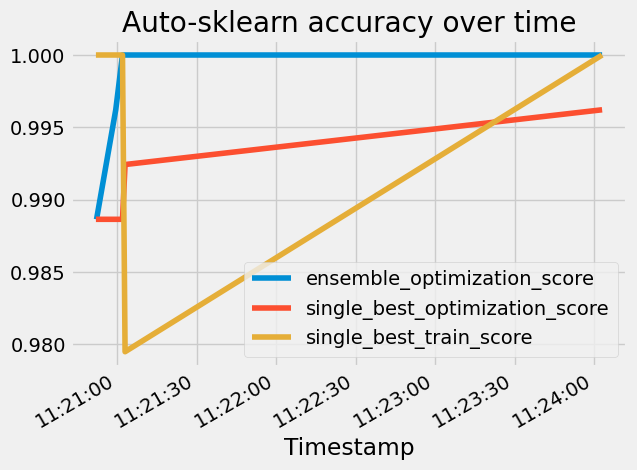

In [ ]:
automl_model.performance_over_time_.plot(
        x='Timestamp',
        kind='line',
        legend=True,
        title='Auto-sklearn accuracy over time',
        grid=True,
    )
plt.show()

In [ ]:
automl_model.show_models()

{3: {'model_id': 3,
  'rank': 1,
  'cost': 0.02651515151515149,
  'ensemble_weight': 0.02,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7fa8fb55de80>,
  'balancing': Balancing(random_state=1, strategy='weighting'),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7fa8fb51ff70>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7fa8fb51f1c0>,
  'sklearn_classifier': MLPClassifier(activation='tanh', alpha=0.00021148999718383549, beta_1=0.999,
                beta_2=0.9, hidden_layer_sizes=(113, 113, 113),
                learning_rate_init=0.0007452270241186694, max_iter=256,
                n_iter_no_change=32, random_state=1, validation_fraction=0.0,
                verbose=0, warm_start=True)},
 4: {'model_id': 4,
  'rank': 2,
  'cost': 0.011363636363636354,
  'ensemble_weight': 0.04,
  'data_preprocessor': <autosklearn.pipeline.c

In [ ]:
automl_model.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
42,2,0.06,random_forest,0.003788,2.264503
43,1,0.06,extra_trees,0.003788,1.902821
6,3,0.08,passive_aggressive,0.007576,1.609075
18,4,0.06,extra_trees,0.007576,2.295887
4,10,0.04,gradient_boosting,0.011364,1.356879
7,9,0.02,gradient_boosting,0.011364,2.321898
17,7,0.02,adaboost,0.011364,2.714477
19,8,0.04,random_forest,0.011364,2.145468
21,6,0.06,gradient_boosting,0.011364,1.629621


In [ ]:
classifier = bestModel

## 5. Raster Inference

## 5.1 Data download

Here we can proceed to perform inference using raster objects. The first step is to download some imagery to test with.

In [ ]:
powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.tif", repo_type='dataset')

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Then we can select all individual band TIF images and stack them to form the raster needed as input to the model. Note that you can skip this step if you already have your raster that includes all bands.

In [ ]:
fileList = sorted([file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'sur_refl' in file])

Then we can perform some feature engineering on the fly to add some additional column features such as NDVI, NDWI1, and NDWI2.

In [ ]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

We end up with a raster M x N x B, where B is the number of column features that will be included in the model input for inference.

In [ ]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 341 ms, sys: 40.8 ms, total: 382 ms
Wall time: 425 ms


### 5.2 Data preparation

Here we convert our raster array into dataframe format to serve as input to the model.

In [ ]:
raster_dataframe = pd.DataFrame(im, columns=v_names, dtype=np.float32)
raster_dataframe

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,1547.0,2461.0,857.0,1256.0,2684.0,2730.0,2222.0,2280.0,-518.0,510.0
1,1474.0,2377.0,857.0,1256.0,2684.0,2730.0,2222.0,2344.0,-691.0,337.0
2,1474.0,2377.0,846.0,1230.0,2630.0,2613.0,2098.0,2344.0,-472.0,623.0
3,1494.0,2461.0,846.0,1230.0,2630.0,2613.0,2098.0,2445.0,-299.0,796.0
4,1494.0,2461.0,846.0,1230.0,2630.0,2613.0,2098.0,2445.0,-299.0,796.0
...,...,...,...,...,...,...,...,...,...,...
1689995,2211.0,2826.0,1080.0,1796.0,3650.0,4266.0,3862.0,1220.0,-2030.0,-1549.0
1689996,2209.0,2801.0,1028.0,1791.0,3633.0,4223.0,3863.0,1181.0,-2024.0,-1593.0
1689997,2358.0,2979.0,1028.0,1791.0,3633.0,4223.0,3863.0,1163.0,-1727.0,-1292.0
1689998,2425.0,3069.0,1117.0,1876.0,3747.0,4345.0,3919.0,1172.0,-1721.0,-1216.0


In [ ]:
def predictRaster(dataframe, model, colsToDrop=None, ):
    """
    Function given a raster in the form of a 
    GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = dataframe.drop(columns=colsToDrop) if colsToDrop else dataframe
    print('Making predictions from raster')
    predictions = model.predict(df).astype(np.int16)
    predictionsProbs = model.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs

Once we have our features in the correct format, we can proceed to perform the inference using the model we previously saved.

In [ ]:
%%time
predictedRaster, predictedProbaRaster = predictRaster(raster_dataframe, classifier)
predictedRaster_automl, predictedProbaRaster_automl = predictRaster(raster_dataframe, automl_model)

Making predictions from raster
Making predictions from raster
CPU times: user 30min 31s, sys: 1min 9s, total: 31min 40s
Wall time: 27min 52s


### 5.3 Reshape the unravelled matrix back to the 4800x4800 raster shape

Here we reshape the raster back into its original shape for further visualization.

In [ ]:
raster_shape = (1300, 1300)
predictedRasterNdArray = np.asarray(predictedRaster)
predictedRasterMatrix = predictedRasterNdArray.reshape(raster_shape)
predictedRasterMatrix.shape

(1300, 1300)

In [ ]:
raster_shape = (1300, 1300)
predictedRasterNdArray_automl = np.asarray(predictedRaster_automl)
predictedRasterMatrix_automl = predictedRasterNdArray_automl.reshape(raster_shape)
predictedRasterMatrix_automl.shape

(1300, 1300)

## 6. Postprocessing

For this particular problem, we will simply apply MODIS QA maks to our output raster as a postprocessing step.

In [ ]:
qa = [file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

Mask out water mask if QA Mask says pixel is "bad".

In [ ]:
raster_qad = np.where(qaMask == 0, predictedRasterMatrix, 255)
raster_qad_automl = np.where(qaMask == 0, predictedRasterMatrix_automl, 255)

We we can plot a view of our water mask prediction.

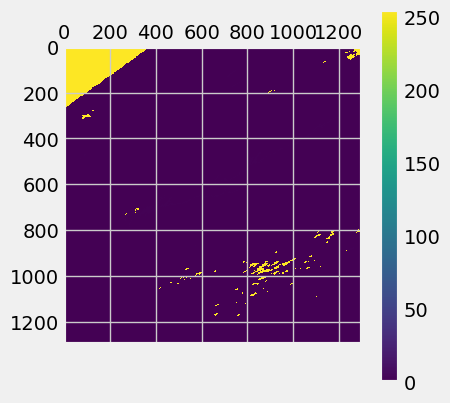

In [ ]:
plt.matshow(raster_qad)
plt.colorbar()

### 7. Output predicted raster to GeoTiff

We can then output our raster array into a GeoTiff file for further analysis. We can produce Cloud Optimized GeoTIFF (COG) files in this step by simply change the 'GTiff' driver to 'COG'.

In [ ]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

predictedPath = 'PowellPredictedWaterMask.tif'

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(raster_qad)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

In [ ]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

predictedPath = 'PowellPredictedWaterMask_automl.tif'

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(raster_qad_automl)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## 8. Visualize your output

We can then proceed to visualize the output of our model in an interactive map. But first, we need to fix the projection in order to properly display the map using the interactive visualization package called folium.

In [ ]:
mask_3857 = folium_helper.reproject_to_3857('PowellPredictedWaterMask.tif')
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


In [ ]:
mask_3857 = folium_helper.reproject_to_3857('PowellPredictedWaterMask_automl.tif')
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb_automl = np.dstack((zeros, mask_b1, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


From there we can define a basemap and the region of interest for our map to initially start.

In [ ]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')


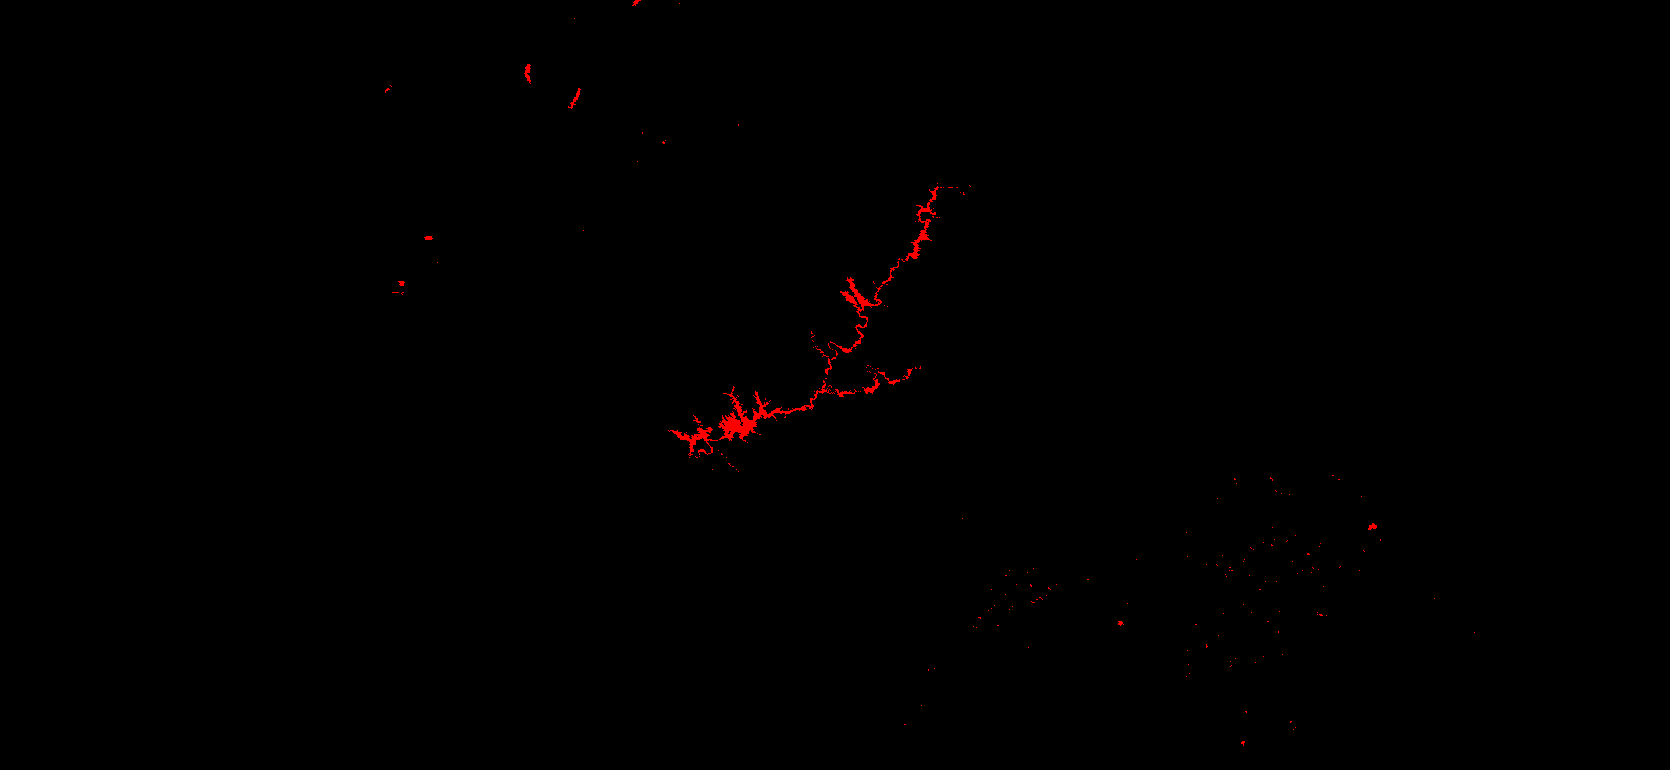
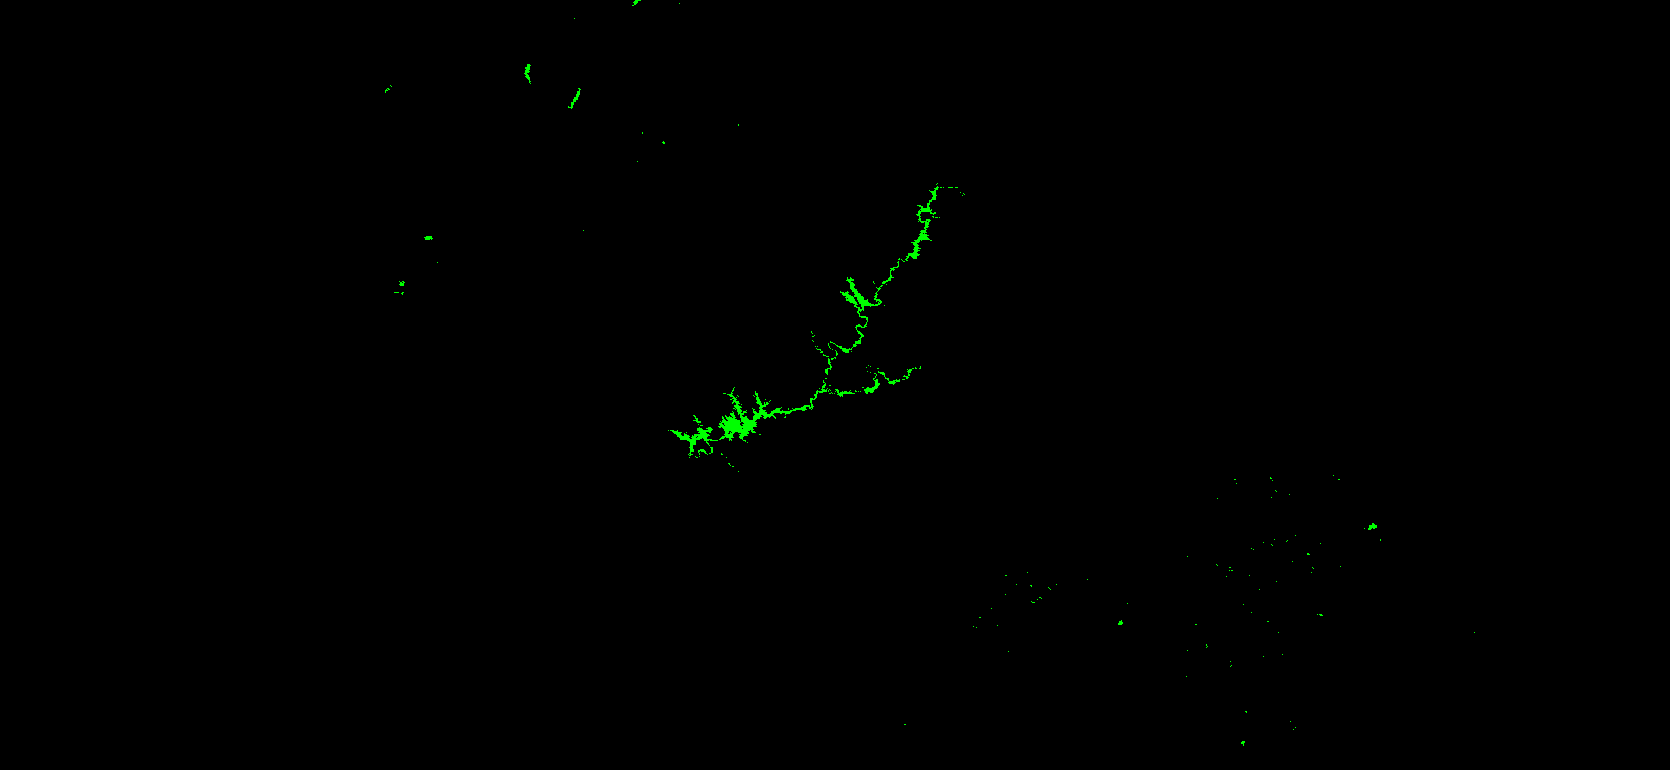

In [ ]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification RF predicted mask', opacity=0.6))
m.add_child(folium_helper.get_overlay(mask_rgb_automl, mask_d, 'Water classification AutoML predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())

## Closing Remarks

We have:

- Trained k-Fold and auto ML models using a binary problem
- We have compared their performance both visually and quantitatively
- AutoML will not always outperform traditional methods, but can be a good start to then enhance the ensemble of models using domain expertise
- The concept of model ensembles can be used across algorithms, and the combination of different models can oftentimes improve model performance